In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = "../Data/Alcohol_Sales.csv"

df = pd.read_csv(PATH, index_col='DATE', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.columns = ['Sales']

In [4]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


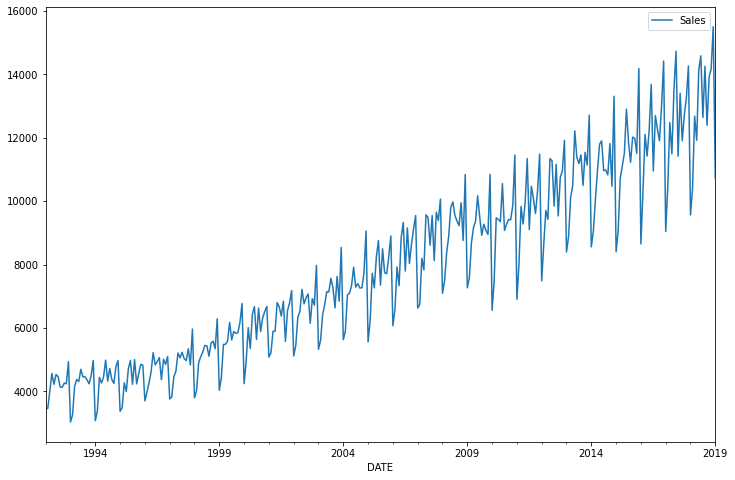

In [5]:
df.plot(figsize=(12,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/nathzi1505/Desktop/Private/Online-Courses/Time-Series/Course_Notebooks/venv/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


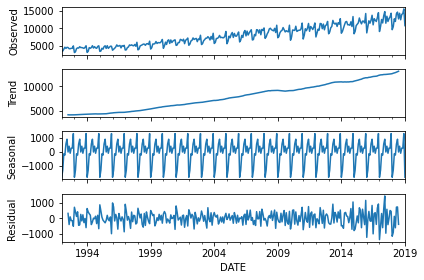

In [7]:
results = seasonal_decompose(df['Sales'])
results.plot();

In [8]:
len(df)

325

In [9]:
# Train Test Split

train = df.iloc[:313]
test = df.iloc[313:]

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [13]:
n_input = 12 # Depends on the seasonality
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input,
                                batch_size=1)

In [14]:
X, y = train_generator[0] # Print X,y for visibility

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [16]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features))) # Start from 100
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit_generator(train_generator, epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0187
Epoch 2/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0084
Epoch 3/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0084
Epoch 4/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0076
Epoch 5/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0060
Epoch 6/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0054
Epoch 7/25
301/301 [==============================] - 3s 8ms/step - loss: 0.0039
Epoch 8/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0032
Epoch 9/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0027
Epoch 10/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0025
Epoch 11/25
301/301 [==============================] - 3s 8ms/step - loss: 0.0028
Epoch 12/25
301/301 [=======

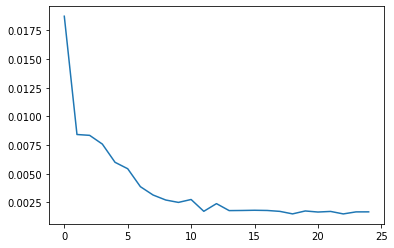

In [19]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [20]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)

In [21]:
true_predictions = scaler.inverse_transform(test_predictions)

In [22]:
test['Predictions'] = true_predictions

/Users/nathzi1505/Desktop/Private/Online-Courses/Time-Series/Course_Notebooks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


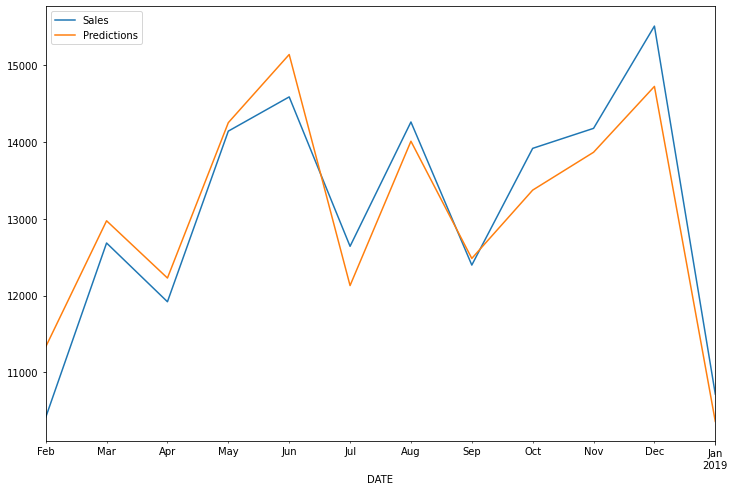

In [23]:
test.plot(figsize=(12,8), legend=True)

In [24]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test['Sales'], test['Predictions']))

483.0828269622148

In [25]:
test['Sales'].mean()

13111.75

In [26]:
model.save('dl1.h5')